# Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem

## Import the modules

In [8]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import sys

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print('tensorflow: ' + tf.__version__)
print('python: ' + sys.version)
print('project_path: ' + os.getcwd())

# os.path.abspath(path)      ---   Return the directory name of pathname path.
data_path = os.path.abspath(os.path.join(os.getcwd(), "../data"))
print('data_path: ' + data_path)

tensorflow: 2.3.0
python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 23:06:31) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
project_path: /Users/yuexiao/Documents/GitHub/machine_learning/Tensorflow/tutorials/ML_basics_with_Keras
data_path: /Users/yuexiao/Documents/GitHub/machine_learning/Tensorflow/tutorials/data


## Download and explore the IMDB dataset

The [**Large Movie Review Dataset**]() that contains the text of 50,000 movie reviews from the [**Internet Movie Database**](). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

In [9]:

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# tf.keras.utils.get_file()  ---   Downloads a file from a URL if it not already in the cache.
# os.path.join(path, *paths) ---   Join one or more path components intelligently. 
dataset = tf.keras.utils.get_file(os.path.join(data_path, "aclImdb_v1.tar.gz"), url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

# os.path.dirname(path)      ---   Return a normalized absolutized version of the pathname path.
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 280s 3us/step


In [11]:
# os.listdir(dataset_dir)    ---   Returns a list containing the names of the entries in the directory given by path. The list is in arbitrary order.
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [12]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [13]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful *text_dataset_from_directory utility*, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to **class_a** and **class_b**. These will be the **positive** and **negative** movie reviews, which can be found in `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [15]:
remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(path, ignore_errors=False, onerror=None) --- Delete an entire directory tree; path must point to a directory (but not a symbolic link to a directory)
shutil.rmtree(remove_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yuexiao/Documents/GitHub/machine_learning/Tensorflow/tutorials/data/aclImdb/train/unsup'

Next, you will use the [**text_dataset_from_directory**]() utility to create a labeled [**tf.data.Dataset**](). [**tf.data**]() is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: **train**, **validation**, and **test**.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the *validation_split* argument below.

In [19]:
batch_size = 32
seed = 42

# tf.keras.preprocessing.text_dataset_from_directory()   ---   Generates a tf.data.Dataset from text files in a directory.
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(data_path, 'aclImdb/train'), 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to ***model.fit***. If you're new to ***tf.data***, you can also iterate over the dataset and print out a few examples as follows.



In [26]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Label 1
Review b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV.<

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the **class_names** property on the dataset.

In [27]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [28]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(data_path, 'aclImdb/train'),
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [24]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(data_path, 'aclImdb/test'),
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful [**preprocessing.TextVectorization**]() layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowecase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [25]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a ***TextVectorization*** layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the ***output_mode*** to ***int*** to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum ***sequence_length***, which will cause the layer to pad or truncate sequences to exactly ***sequence_length*** values.

In [29]:
max_features = 10000
sequence_length = 250

# TextVectorization
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call [**adapt**]() to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [33]:
# Make a text-only dataset (without labels), then call adapt

# normal map() and lambda
# map()   ---   function returns a map object(which is an iterator) of the results after applying the given function to each item of a given iterable (list, tuple etc.)
# lambda The lambda operator or lambda function is a way to create small anonymous functions. 
#        i.e. functions without a name. These functions are throw-away functions, 
#        i.e. they are just needed where they have been created
# Lambda functions are mainly used in combination with the functions filter(), map() and reduce().


# tf.data.map()   ---   Maps map_func across the elements of this dataset.
train_text = raw_train_ds.map(lambda x, y: x)
# TextVectorization.adapt()   ---   Fits the state of the preprocessing layer to the dataset.
vectorize_layer.adapt(train_text)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Let's create a function to see the result of using this layer to preprocess some data.

In [60]:
def vectorize_text(text, label):
    # tf.expand_dims
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [43]:
# retrieve a batch (of 32 reviews and labels) from the dataset
# next()   ---   retrieves next item from the iterator
# iter()   ---   creates an object which can be iterated one element at a time.
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"Emma" was a product of what might be called by the First Great Jane Austen Cycle of the mid-nineties, and it was recently shown on British television, doubtless because of the interest in the author created by the Second Great Jane Austen Cycle which started with "Pride and Prejudice" two years ago. We currently have in the cinemas the Austen biopic "Becoming Jane", and ITV have recently produced three TV movies based on Austen novels. These include "Northanger Abbey", the only one of the six major novels not to have been filmed previously, so the cycle should now be complete. No doubt, however, there will be more to come in the near future. (There is, after all, her juvenile "Love and Freindship" (sic), the short novella "Lady Susan", and someone, somewhere, has doubtless supplied endings to her two unfinished fragments "The Watsons" and "Sanditon". Then there are all those Austen sequels churned out by modern writers\xc2\x85\xc2\x85\xc2\x85).<br /><br />The main c

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling [**.get_vocabulary()**]() on the layer.

In [46]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [47]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

[**.cache()**](https://www.tensorflow.org/guide/data_performance#caching) keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

[**.prefetch()**](https://www.tensorflow.org/guide/data_performance#prefetching) overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [49]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, see the [**word embedding tutorial**](https://www.tensorflow.org/tutorials/text/word_embeddings).
Next, a [**GlobalAveragePooling1D**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
This fixed-length output vector is piped through a fully-connected ([**Dense**]()) layer with 16 hidden units.
The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use [**losses.BinaryCrossentropy**]() loss function.

Now, configure the model to use an optimizer and a loss function:

In [50]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the dataset object to the fit method.

In [51]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
623/625 [============================>.] - ETA: 0s - loss: 0.6664 - binary_accuracy: 0.6924WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8b94a8ed90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=

## Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [53]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3104 - binary_accuracy: 0.8731
Loss:  0.3104218542575836
Accuracy:  0.8731200098991394


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

[**model.fit()**]() returns a [**History**]() object that contains a dictionary with everything that happened during training:

In [54]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

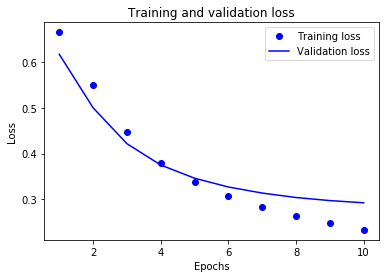

In [55]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

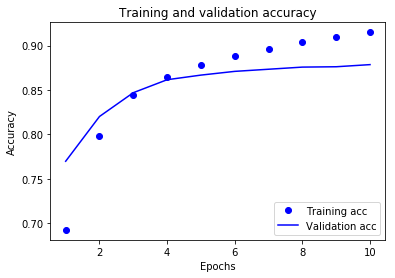

In [56]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the [**EarlyStopping callback**]().

## Export the mode

In the code above, you applied the **TextVectorization** layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the **TextVectorization** layer inside your model. To do so, you can create a new model using the weights you just trained.



In [59]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
782/782 [==============================] - 11s 14ms/step - loss: 0.3104 - accuracy: 0.8731
0.8731200098991394


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [**train/test skew**](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [**tutorial**](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.